In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cascid.datasets.pipeline.load_dataset import train_test_split
from cascid.datasets.isic.fetcher import fetch_from_isic, save_metadata, download_image
from cascid.image import apply_preprocessing

In [54]:
image_metadata = pd.read_csv(r'C:\Users\samuel.nporto\.cascid_data\ISIC\metadata.csv', index_col=0)

image_metadata['is_cancer'] = image_metadata['diagnostic'].apply(lambda x: 1 if x in ['melanoma', 'basal cell carcinoma', 'squamous cell carcinoma'] else 0)

image_metadata

,isic_id,sex,diagnostic,age_approx,image_url,img_id,is_cancer
0,ISIC_6892286,male,melanoma,75,https://content.isic-archive.com/e854396c-7cae...,ISIC_6892286.jpg,1
1,ISIC_9214649,male,melanoma,60,https://content.isic-archive.com/c7069eb7-7394...,ISIC_9214649.jpg,1
2,ISIC_3056854,male,melanoma,75,https://content.isic-archive.com/45f9a250-e9c7...,ISIC_3056854.jpg,1
3,ISIC_7755096,male,melanoma,45,https://content.isic-archive.com/78d98772-82b9...,ISIC_7755096.jpg,1
4,ISIC_9859873,female,melanoma,75,https://content.isic-archive.com/d8e858ca-c0dc...,ISIC_9859873.jpg,1
...,...,...,...,...,...,...,...
595,ISIC_0070213,male,squamous cell carcinoma,85,https://content.isic-archive.com/1f2f57ba-df7d...,ISIC_0070213.jpg,1
596,ISIC_0070157,male,squamous cell carcinoma,75,https://content.isic-archive.com/2b1b32d5-7fac...,ISIC_0070157.jpg,1
597,ISIC_0070083,male,squamous cell carcinoma,65,https://content.isic-archive.com/9e9fe854-d36f...,ISIC_0070083.jpg,1
598,ISIC_0070041,female,squamous cell carcinoma,65,https://content.isic-archive.com/24a2a7f9-717d...,ISIC_0070041.jpg,1


In [3]:
def rotateImage(image, angle, center):
    row,col, *c = image.shape # Get image shape, discarding any color channels available
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0) # Make a rotation matrix using
    new_image = cv2.warpAffine(image, rot_mat, (col,row))
    return new_image

# Feature Extraction for 1 Image

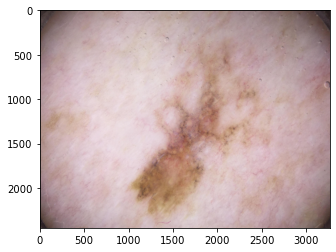

In [65]:
path = r"C:/Users/samuel.nporto/.cascid_data/ISIC/"

im = plt.imread(path + image_metadata.iloc[10].img_id)

plt.imshow(im)

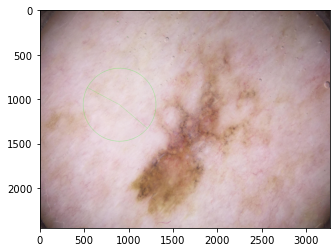

In [66]:
# Initiate ORB detector
orb = cv2.SIFT_create()
# find the keypoints with ORB
kp = orb.detect(im,None)
# compute the descriptors with ORB
kp, des = orb.compute(im, kp)
# draw
img2 = cv2.drawKeypoints(im, kp[:10], None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2)
plt.show();

In [67]:
kp[0].pt, kp[0].angle

((52.16022872924805, 1993.9813232421875), 42.48980712890625)

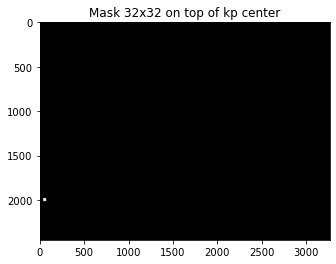

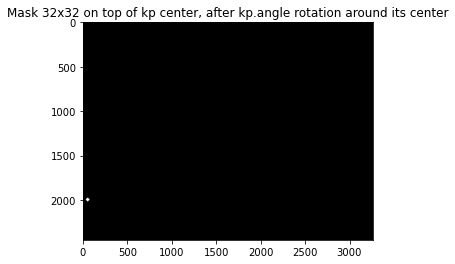

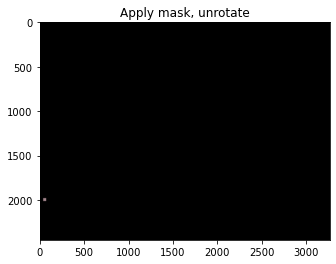

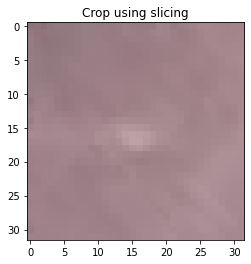

(327, 1024)


In [71]:
width = 32
plot_example = True
M = list()
for i in range(len(kp)):
    x = int(kp[i].pt[0]) # int conversion
    y = int(kp[i].pt[1]) # int conversion
    angle = kp[i].angle # angle in deg

    # Check for boundary
    if x<width//2 or x > (im.shape[1] - width//2) or y<width//2 or y > (im.shape[0] - width//2):
        continue

    mask = np.zeros_like(im) # black mask 
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY) # grayscale
    mask = cv2.rectangle(mask, (x-width//2, y+width//2), (x+width//2, y-width//2), 255, -1) # draw square
    mask_rot = rotateImage(mask, angle, (x,y)) # rotate square by angle
    roi = cv2.bitwise_and(im, im, mask=mask_rot) # Select mask region
    roi = rotateImage(roi, -angle, (x,y)) # unrotate
    roi_32 = roi[ y-width//2 : y+width//2 , x-width//2 : x+width//2 ] # crop
    if plot_example:
        plt.imshow(mask, cmap='gray')
        plt.title('Mask 32x32 on top of kp center')
        plt.show()
        plt.imshow(mask_rot, cmap='gray')
        plt.title('Mask 32x32 on top of kp center, after kp.angle rotation around its center')
        plt.show()
        plt.imshow(roi)
        plt.title('Apply mask, unrotate')
        plt.show()
        plt.imshow(roi_32)
        plt.title('Crop using slicing')
        plt.show()
        plot_example = False # Only show first
    roi_32 = cv2.cvtColor(roi_32, cv2.COLOR_RGB2LAB) # Convert to CIE-LAB
    roi_32 = roi_32[:,:,0] # Keep only L
    M.append(roi_32.flatten())
M = np.array(M)
print(M.shape)

In [15]:
u, s, vh = np.linalg.svd(M, full_matrices=False)

print(u.shape)
print(s.shape)
print(vh.shape)

(327, 327)
(327,)
(327, 1024)


In [16]:
for e in range(len(s)):
    vh[e] = s[e]*vh[e]

In [30]:
result = np.zeros(len(vh[0]))

for e in vh:
    result += e

result

array([-3103.41752471, -3190.58613799, -3105.44557458, ...,
       -3311.60008311, -3285.27394565, -3259.07956722])

In [44]:
result_dict = { f"result_{i}" : result[i] for i in range(0, len(result) ) }

result_serie = pd.Series(result_dict)

result_serie[:10]

result_0   -3103.417525
result_1   -3190.586138
result_2   -3105.445575
result_3   -3121.560069
result_4   -3110.458992
result_5   -3137.653137
result_6   -3162.615181
result_7   -3123.264305
result_8   -2927.103283
result_9   -2742.341351
dtype: float64

In [48]:
print(image_metadata.iloc[10].img_id)

image_metadata.loc[image_metadata.index == 10, result_serie.index] = result_serie.values

image_metadata.loc[image_metadata.index == 10]

ISIC_6668093.jpg


,isic_id,sex,diagnostic,age_approx,image_url,img_id,result_0,result_1,result_2,result_3,...,result_1014,result_1015,result_1016,result_1017,result_1018,result_1019,result_1020,result_1021,result_1022,result_1023
10,ISIC_6668093,female,melanoma,80,https://content.isic-archive.com/34db9cb5-e32c...,ISIC_6668093.jpg,-3103.417525,-3190.586138,-3105.445575,-3121.560069,...,-3482.495809,-3436.620631,-3421.868113,-3384.413624,-3390.890054,-3410.339175,-3414.859409,-3311.600083,-3285.273946,-3259.079567


# Model Classification

In [77]:
for idx in range(len(image_metadata)):
    im = plt.imread(path + image_metadata.iloc[idx].img_id)
    
    # Initiate ORB detector
    orb = cv2.SIFT_create()
    # find the keypoints with ORB
    kp = orb.detect(im,None)
    # compute the descriptors with ORB
    kp, des = orb.compute(im, kp)
    
    width = 32
    M = list()
    for i in range(len(kp)):
        x = int(kp[i].pt[0]) # int conversion
        y = int(kp[i].pt[1]) # int conversion
        angle = kp[i].angle # angle in deg
        
        # Check for boundary
        if x<width//2 or x > (im.shape[1] - width//2) or y<width//2 or y > (im.shape[0] - width//2):
            continue
        
        mask = np.zeros_like(im) # black mask 
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY) # grayscale
        mask = cv2.rectangle(mask, (x-width//2, y+width//2), (x+width//2, y-width//2), 255, -1) # draw square
        mask_rot = rotateImage(mask, angle, (x,y)) # rotate square by angle
        roi = cv2.bitwise_and(im, im, mask=mask_rot) # Select mask region
        roi = rotateImage(roi, -angle, (x,y)) # unrotate
        roi_32 = roi[ y-width//2 : y+width//2 , x-width//2 : x+width//2 ] # crop
        roi_32 = cv2.cvtColor(roi_32, cv2.COLOR_RGB2LAB) # Convert to CIE-LAB
        roi_32 = roi_32[:,:,0] # Keep only L
        M.append(roi_32.flatten())
    M = np.array(M)
    
    u, s, vh = np.linalg.svd(M, full_matrices=False)

    for e in range(len(s)):
        vh[e] = s[e]*vh[e]

    result = np.zeros(len(vh[0]))

    for e in vh:
        result += e
    
    result_dict = { f"result_{i}" : result[i] for i in range(0, len(result) ) }

    result_serie = pd.Series(result_dict)
    
    image_metadata.loc[image_metadata.index == idx, result_serie.index] = result_serie.values

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(
    image_metadata.drop(['is_cancer', 'diagnostic', 'isic_id', 'sex', 'image_url', 'img_id'], axis=1),
    image_metadata['is_cancer'],
    test_size = 0.2,
    random_state=RANDOM_SEED,
)
y_train_bin = y_train_bin.astype(np.float64)
y_test_bin = y_test_bin.astype(np.float64)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Greens, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=sorted(classes), yticklabels=sorted(classes),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig(title + '.png')
    return ax

def eval_model(model, x_test, y_test, title, *, classes=None):
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:,1]
    if classes:
        classes_list = classes
    else:
        classes_list = list(set(y_test))
        
    plot_confusion_matrix(y_test, y_pred, classes_list, normalize=True, title=title, save_to_file=True)

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

print("\nBinary RFC")
rfc_clf_bin = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=150)
rfc_clf_bin.fit(x_train_bin, y_train_bin)
eval_model(rfc_clf_bin, x_test_bin, y_test_bin, title="Binary Random Forest Classifier Confusion Matrix", classes=["Not Cancer", "Cancer"])
tr = cross_val_score(rfc_clf_bin, x_train_bin, y_train_bin, cv=3, scoring='accuracy')
tst = cross_val_score(rfc_clf_bin, x_test_bin, y_test_bin, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

# Feature Importances

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [h for h in np.arange(50,250,25)],
    'max_features': [k for k in np.arange(1,image_metadata.shape[1])]
}
grid = GridSearchCV(rfc_clf_bin,
                    params,
                    cv = 4,
                    scoring='accuracy',
                    return_train_score=True,
                    n_jobs=-1
)

grid.fit(x_train_bin,y_train_bin)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=150,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [50, 75, 100, 125, 150, 175, 200,
                                          225]},
             return_train_score=True, scoring='accuracy')

In [ ]:
feature_importances = grid.best_estimator_.feature_importances_
importance_list = sorted(zip(feature_importances, y_train_bin.columns.values), reverse=True)
importance_list

[(0.41340669173830036, 'age'),
 (0.10848588950384475, 'smoke'),
 (0.06307341505075953, 'drink'),
 (0.049269508091808134, 'skin_cancer_history'),
 (0.04833608712966853, 'cancer_history'),
 (0.04631346437019466, 'pesticide'),
 (0.035528990577407035, 'has_sewage_system'),
 (0.03449801828847836, 'onehotencoder__x0_OUTROS'),
 (0.033405957805392045, 'onehotencoder__x0_FOREARM'),
 (0.029262709832817174, 'onehotencoder__x0_BACK'),
 (0.027181551276403138, 'has_piped_water'),
 (0.02384854883255085, 'onehotencoder__x0_HAND'),
 (0.022392349544521534, 'onehotencoder__x0_FACE'),
 (0.018985002991006517, 'onehotencoder__x0_ARM'),
 (0.01672771576031111, 'onehotencoder__x0_CHEST'),
 (0.01078226029299768, 'onehotencoder__x0_EAR'),
 (0.010680012560533619, 'onehotencoder__x0_NOSE'),
 (0.007821826353005113, 'onehotencoder__x0_NECK')]

In [ ]:
grid.best_params_

{'max_features': 8, 'n_estimators': 100}

In [ ]:
grid.best_estimator_

NameError: name 'grid' is not defined